In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys; sys.path.insert(0,'C:/Users/Micah/Documents/clustering_for_dummies/ca45_clustering_imports')
import fileread as fr; import wave_ops as wo; import predefined as pd
from sklearn.cluster import OPTICS
from scipy.spatial import distance_matrix

In [2]:
colors = {}
colors[0] = 'r'
colors[1] = 'g'
colors[2] = 'b'
colors[3] = 'c'
colors[4] = 'm'
colors[5] = 'y'
colors[6] = 'lime'
colors[7] = 'navy'
colors[8] = 'pink'
colors[9] = 'khaki'
colors[10] = 'peru'
colors[11] = 'aqua'
colors[12] = 'darkorchid'
colors[13] = 'rosybrown'
colors[14] = 'lightgrey'
colors[15] = 'wheat'
colors[16] = 'gold'
colors[17] = 'aquamarine'
colors[18] = 'springgreen'
colors[19] = 'deeppink'
colors[20] = 'crimson'
colors[-1] = 'k'

In [3]:
runs=[run for run in os.listdir('C:/Users/Micah/Documents/clustering_for_dummies')       if run.endswith('.bin') and run[4:-6]!='186']
runs.sort()
print(runs)
path='C:/Users/Micah/Documents/clustering_for_dummies/'
proc_data=fr.gen_output(path+'Run_60-all.dat')[0]

bdch=11#35
bd,ch=divmod(bdch,8)
cal=pd.calibration[(pd.calibration.board==bd)*(pd.calibration.channel==ch)][0]


mn,mx=0,1460
t=(proc_data.board==bd)*(proc_data.channel==ch)*(proc_data.energy<mx)
proc_data=proc_data[t]

['Run_60_0.bin']


In [4]:
wfs=[]
path='C:/Users/Micah/Documents/clustering_for_dummies/'

for run in runs:
    numwaves=int((os.stat(path+run).st_size-8)/(7033))
    numwaves=20000
    data=fr.raw(path+run,length=3500,numwaves=numwaves,row=1000).view(np.recarray)
    t=(data.board==bd)*(data.channel==ch)
    data=data[t]
    wo.baseline_restore(data,pretrigger=600)
    maxes=np.amax(data.wave,axis=1)
    t=(maxes>mn)*(maxes<mx)
    data=data[t]
    tot=len(proc_data)
    for i,stamp in enumerate(proc_data.timestamp):
        if divmod(i,100)[1]==0:
            print('\r'+30*' ',end='')
            print('\r'+'{:0d}% of '.format(int(100*i/tot))+run,end='')
        l=np.nonzero(data.timestamp==stamp)[0]
        if l.shape[0]>0:
            wfs.append(data[l[0]])

wfs=np.asarray(wfs).view(np.recarray)

99% of Run_60_0.bin           

In [5]:
X=wfs.wave[0:len(wfs)].copy().astype('f4')

In [6]:
x_norm = np.zeros_like(X)

In [7]:
def normBatch(x):
    for i in range(len(x)):
        x_norm[i] = x[i] - np.amin(x[i])
        x_norm[i] = x_norm[i]*2./np.amax(x[i])
        x_norm[i] = x_norm[i] - 1

In [8]:
normBatch(X)

In [9]:
u, s, vh = np.linalg.svd(x_norm, full_matrices=False)

(0, 20)

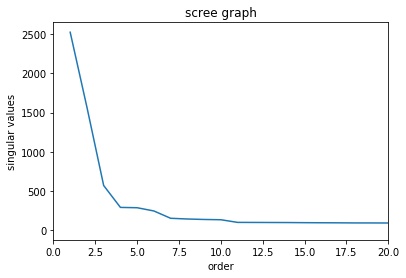

In [10]:
scree_order = np.arange(1,len(s)+1)
plt.plot(scree_order, s)
plt.title("scree graph")
plt.ylabel("singular values")
plt.xlabel("order")
plt.xlim(0,20)

In [11]:
variance = np.zeros_like(s)
for i in range(len(s)):
    variance[i] = s[i]**2
total_variance = 0
for i in range(len(variance)):
    total_variance += variance[i]

In [12]:
pvc = np.zeros_like(variance)
for i in range(len(pvc)):
    pvc[i] = variance[i] + pvc[i-1]
for i in range(len(pvc)):
    pvc[i] = pvc[i] / total_variance

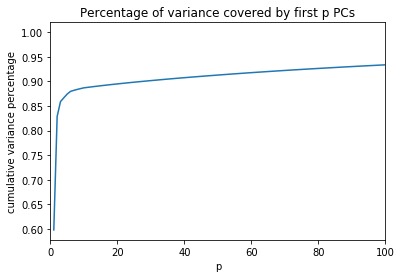

In [13]:
plt.plot(scree_order, pvc)
plt.title('Percentage of variance covered by first p PCs')
plt.xlabel('p')
plt.ylabel('cumulative variance percentage')
plt.xlim(0,100)
percent_var_fig = plt.gcf()

In [14]:
v = np.transpose(vh)
reduced_norm_data = x_norm@v

In [15]:
M = np.zeros([4250,2])
M[:,0] = reduced_norm_data[:,0]
M[:,1] = reduced_norm_data[:,1]

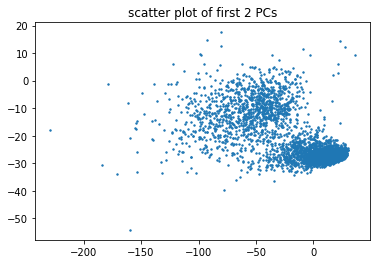

In [16]:
x = M[:,0] 
y = M[:,1]
plt.scatter(x,y, s= 2)
plt.title("scatter plot of first 2 PCs")
scatter_fig = plt.gcf()

In [17]:
norm_dist = distance_matrix(M, M)

In [18]:
count = 0
temp = np.triu(norm_dist,1)
distances = np.asarray(temp).reshape(-1)
distances = np.sort(distances)
distances = np.flip(distances)

In [19]:
l = len(norm_dist)
nonzeros = int((l*l - l)/2)
order = np.arange(nonzeros)

In [20]:
distances = distances[0:nonzeros]

(0, 30)

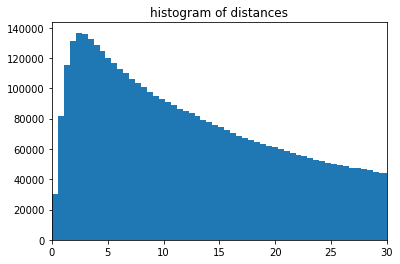

In [21]:
plt.title("histogram of distances")
plt.hist(distances, 500)
plt.xlim(0,30)

In [22]:
clustering = OPTICS(min_samples = 10, cluster_method = 'dbscan', eps = 2.7, min_cluster_size = 0.02).fit(M)
labels = clustering.labels_
cvec = [colors[label] for label in labels]
count = 0
for i in range(len(labels)):
    if labels[i] != -1:
        count +=1
print("percentage of data in clusters: " + str(round(100*count/len(labels),2)))
num_clusts = np.max(labels)+1
print("number of clusters: " + str(num_clusts))

percentage of data in clusters: 90.68
number of clusters: 5


In [23]:
space = np.arange(len(M))
order = clustering.ordering_
reachability = clustering.reachability_[order]

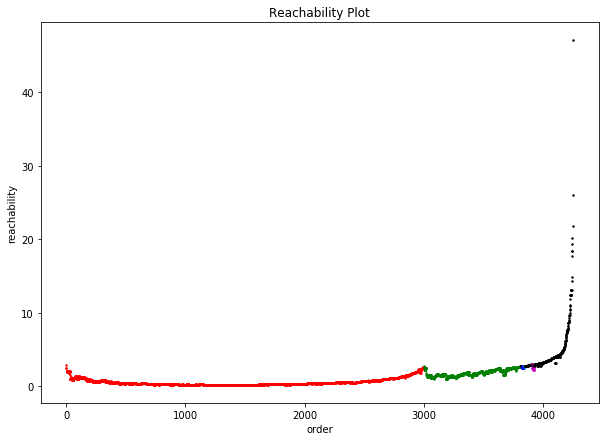

In [24]:
fig, ax = plt.subplots(figsize = (10,7))
for i in range(len(M)):
    ax.scatter(space[i], reachability[i], c = cvec[order[i]], s=2)
ax.title.set_text("Reachability Plot")
ax.set_xlabel("order")
ax.set_ylabel("reachability")
reach_plot = plt.gcf()
plt.show()

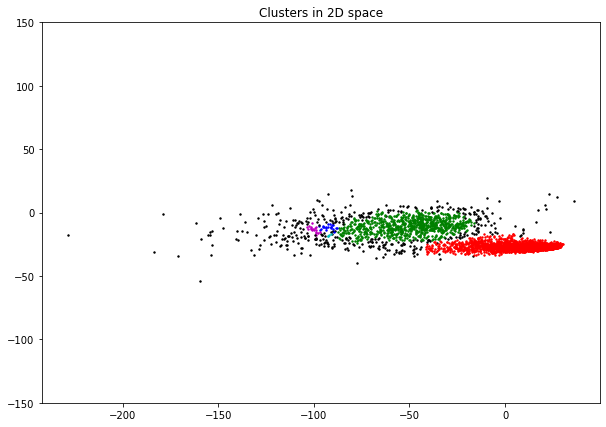

In [25]:
fig, ax = plt.subplots(figsize = (10,7))
for i in range(len(M)):
    ax.scatter(M[:,0][i], M[:,1][i], c = cvec[i], s=2)
ax.title.set_text("Clusters in 2D space")
ax.set_ylim(-150,150)
clusters_2D = plt.gcf()
plt.show()

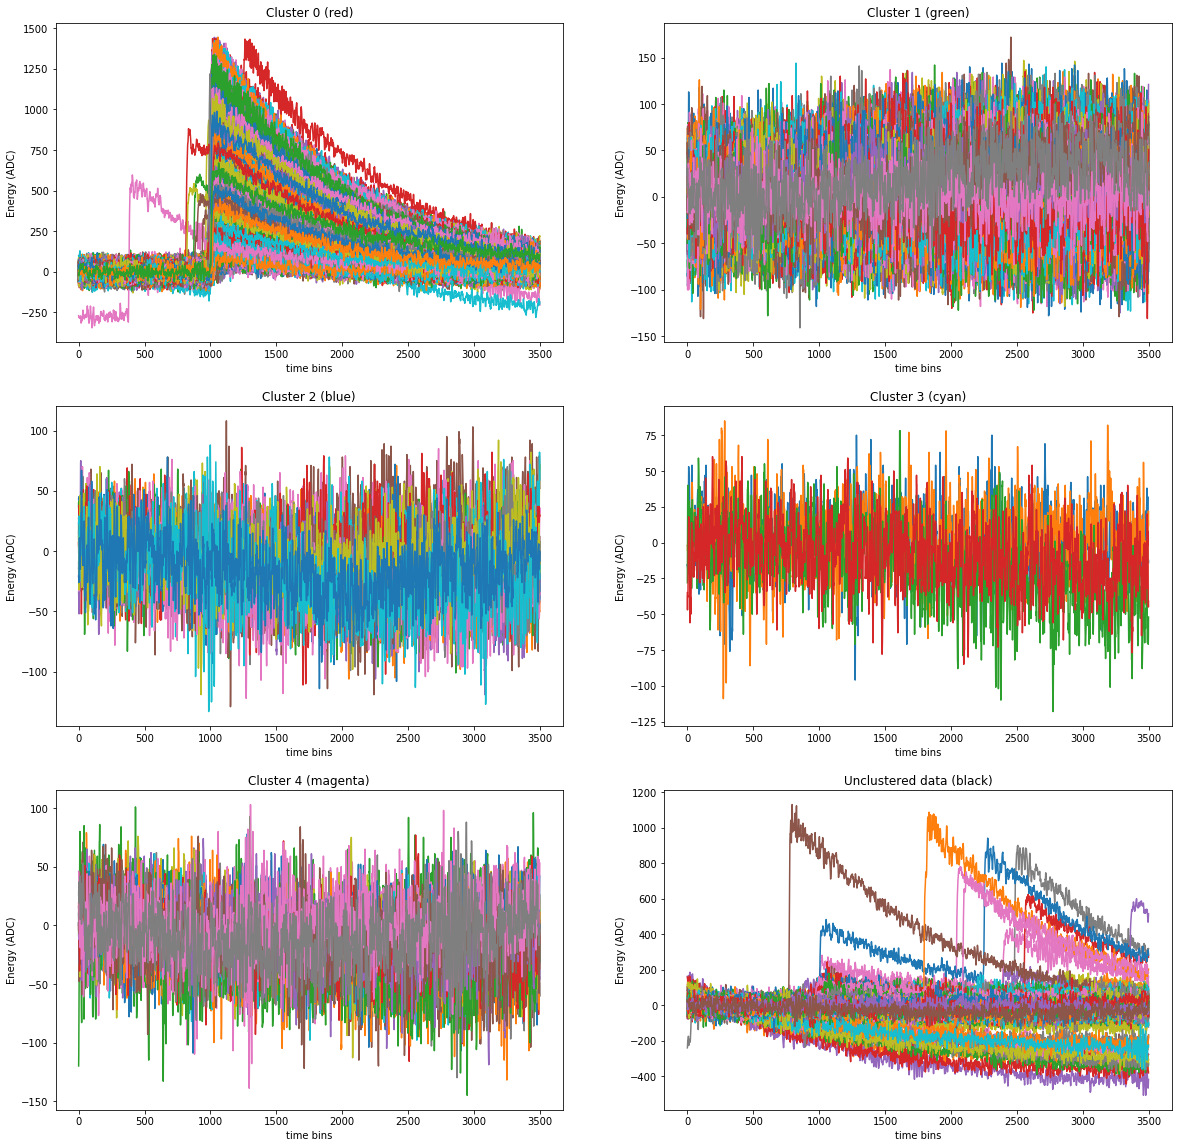

In [26]:
fig, ax = plt.subplots(3,2, figsize = (20, 20))
t = np.arange(3500)
for n in range(len(labels)):
    if labels[n] == 0:
        ax[0,0].plot(t, X[n])
        ax[0,0].title.set_text("Cluster 0 (red)")
        ax[0,0].set_xlabel("time bins")
        ax[0,0].set_ylabel("Energy (ADC)")
    if labels[n] == 1:
        ax[0,1].plot(t, X[n])
        ax[0,1].title.set_text("Cluster 1 (green)")
        ax[0,1].set_xlabel("time bins")
        ax[0,1].set_ylabel("Energy (ADC)")
    if labels[n] == 2:
        ax[1,0].plot(t, X[n])
        ax[1,0].title.set_text("Cluster 2 (blue)")
        ax[1,0].set_xlabel("time bins")
        ax[1,0].set_ylabel("Energy (ADC)")
    if labels[n] == 3:
        ax[1,1].plot(t, X[n])
        ax[1,1].title.set_text("Cluster 3 (cyan)")
        ax[1,1].set_xlabel("time bins")
        ax[1,1].set_ylabel("Energy (ADC)")
    if labels[n] == 4:
        ax[2,0].plot(t, X[n])
        ax[2,0].title.set_text("Cluster 4 (magenta)")
        ax[2,0].set_xlabel("time bins")
        ax[2,0].set_ylabel("Energy (ADC)")
    if labels[n] == -1:
        ax[2,1].plot(t, X[n])
        ax[2,1].title.set_text("Unclustered data (black)")
        ax[2,1].set_xlabel("time bins")
        ax[2,1].set_ylabel("Energy (ADC)")
wf_in_clusters = plt.gcf()
plt.show()

In [28]:
for i in range(3001):
    labels[order[i]] = 0
for i in range(3001, 4100):
    labels[order[i]] = 1
for i in range(4101, 4150):
    labels[order[i]] = -1
cvec = [colors[label] for label in labels]

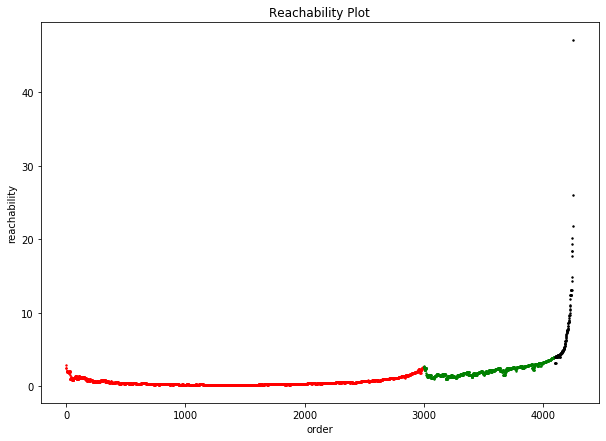

In [29]:
fig, ax = plt.subplots(figsize = (10,7))
for i in range(len(M)):
    ax.scatter(space[i], reachability[i], c = cvec[order[i]], s=2)
ax.title.set_text("Reachability Plot")
ax.set_xlabel("order")
ax.set_ylabel("reachability")
reach_plot = plt.gcf()
plt.show()

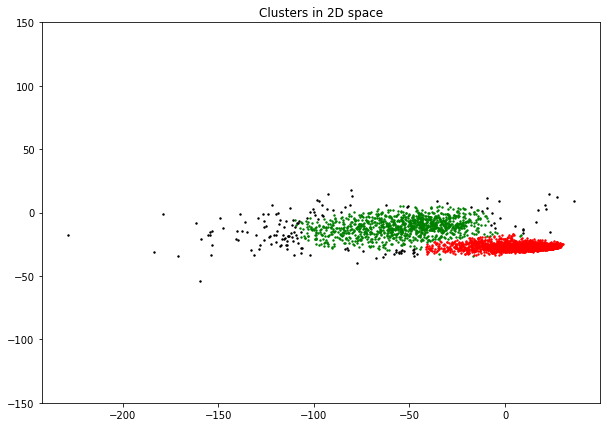

In [30]:
fig, ax = plt.subplots(figsize = (10,7))
for i in range(len(M)):
    ax.scatter(M[:,0][i], M[:,1][i], c = cvec[i], s=2)
ax.title.set_text("Clusters in 2D space")
ax.set_ylim(-150,150)
clusters_2D = plt.gcf()
plt.show()

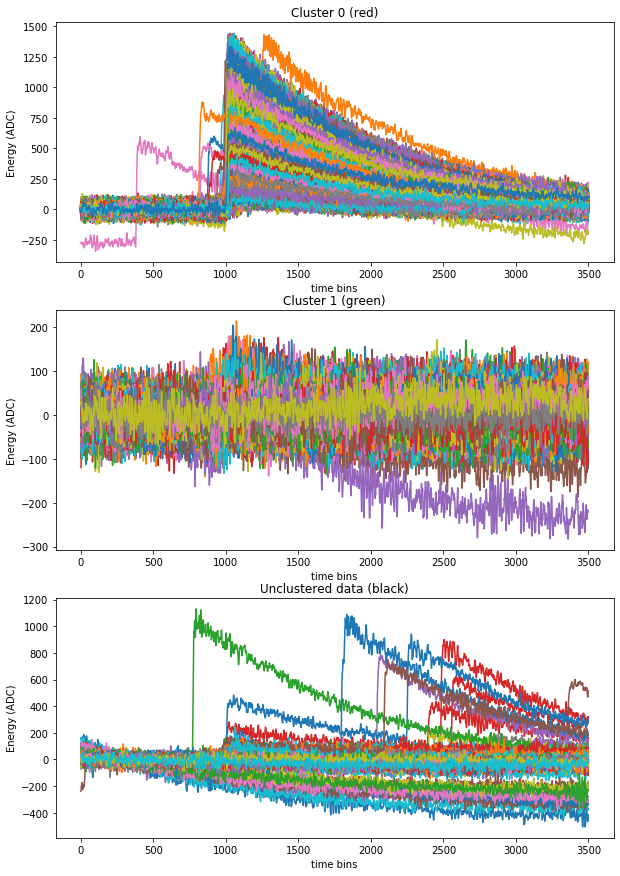

In [31]:
fig, ax = plt.subplots(3,1, figsize = (10, 15))
t = np.arange(3500)
for n in range(len(labels)):
    if labels[n] == 0:
        ax[0].plot(t, X[n])
        ax[0].title.set_text("Cluster 0 (red)")
        ax[0].set_xlabel("time bins")
        ax[0].set_ylabel("Energy (ADC)")
    if labels[n] == 1:
        ax[1].plot(t, X[n])
        ax[1].title.set_text("Cluster 1 (green)")
        ax[1].set_xlabel("time bins")
        ax[1].set_ylabel("Energy (ADC)")
    if labels[n] == -1:
        ax[2].plot(t, X[n])
        ax[2].title.set_text("Unclustered data (black)")
        ax[2].set_xlabel("time bins")
        ax[2].set_ylabel("Energy (ADC)")
wf_in_clusters = plt.gcf()
plt.show()

#### **Now perform energy cuts**

In [32]:
runs=[run for run in os.listdir('C:/Users/Micah/Documents/clustering_for_dummies')       if run.endswith('.bin') and run[4:-6]!='186']
runs.sort()
print(runs)
path='C:/Users/Micah/Documents/clustering_for_dummies/'
proc_data=fr.gen_output(path+'Run_60-all.dat')[0]

bdch=11#35
bd,ch=divmod(bdch,8)
cal=pd.calibration[(pd.calibration.board==bd)*(pd.calibration.channel==ch)][0]


mn,mx=200,1460
proc_data=pd.precuts(proc_data,energy=mn).view(np.recarray)
t=(proc_data.board==bd)*(proc_data.channel==ch)*(proc_data.energy<mx)
proc_data=proc_data[t]

['Run_60_0.bin']


In [33]:
wfs=[]
path='C:/Users/Micah/Documents/clustering_for_dummies/'

for run in runs:
    numwaves=int((os.stat(path+run).st_size-8)/(7033))
    numwaves=20000
    data=fr.raw(path+run,length=3500,numwaves=numwaves,row=1000).view(np.recarray)
    t=(data.board==bd)*(data.channel==ch)
    data=data[t]
    wo.baseline_restore(data,pretrigger=600)
    maxes=np.amax(data.wave,axis=1)
    t=(maxes>mn)*(maxes<mx)
    data=data[t]
    tot=len(proc_data)
    for i,stamp in enumerate(proc_data.timestamp):
        if divmod(i,100)[1]==0:
            print('\r'+30*' ',end='')
            print('\r'+'{:0d}% of '.format(int(100*i/tot))+run,end='')
        l=np.nonzero(data.timestamp==stamp)[0]
        if l.shape[0]>0:
            wfs.append(data[l[0]])

wfs=np.asarray(wfs).view(np.recarray)

99% of Run_60_0.bin           

In [34]:
X=wfs.wave[0:len(wfs)].copy().astype('f4')
x_norm = np.zeros_like(X)
normBatch(X)

In [35]:
u, s, vh = np.linalg.svd(x_norm, full_matrices=True)
scree_order = np.arange(1, len(s)+1)

(0, 20)

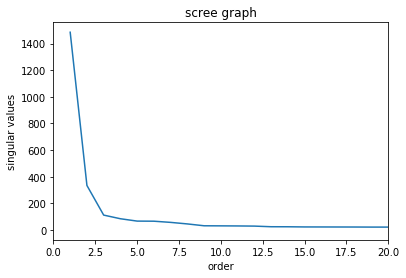

In [36]:
scree_order = np.arange(1,len(s)+1)
plt.plot(scree_order, s)
plt.title("scree graph")
plt.ylabel("singular values")
plt.xlabel("order")
plt.xlim(0,20)

In [37]:
variance = np.zeros_like(s)
for i in range(len(s)):
    variance[i] = s[i]**2
total_variance = 0
for i in range(len(variance)):
    total_variance += variance[i]

In [38]:
pvc = np.zeros_like(variance)
for i in range(len(pvc)):
    pvc[i] = variance[i] + pvc[i-1]
for i in range(len(pvc)):
    pvc[i] = pvc[i] / total_variance

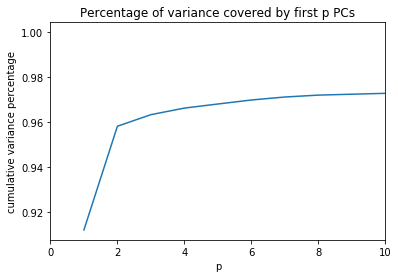

In [39]:
plt.plot(scree_order, pvc)
plt.title('Percentage of variance covered by first p PCs')
plt.xlabel('p')
plt.ylabel('cumulative variance percentage')
plt.xlim(0,10)
percent_var_fig = plt.gcf()

In [40]:
v = np.transpose(vh)
reduced_norm_data = x_norm@v

In [41]:
M = np.zeros([2070,2])
M[:,0] = reduced_norm_data[:,0]
M[:,1] = reduced_norm_data[:,1]

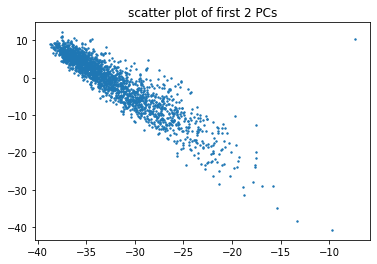

In [42]:
x = M[:,0] 
y = M[:,1]
plt.scatter(x,y, s= 2)
plt.title("scatter plot of first 2 PCs")
scatter_fig = plt.gcf()

In [43]:
clustering = OPTICS(min_samples = 10, cluster_method = 'dbscan', eps = 0.8, min_cluster_size = 0.02).fit(M)
labels = clustering.labels_
cvec = [colors[label] for label in labels]
count = 0
for i in range(len(labels)):
    if labels[i] != -1:
        count +=1
print("percentage of data in clusters: " + str(round(100*count/len(labels),2)))
num_clusts = np.max(labels)+1
print("number of clusters: " + str(num_clusts))

percentage of data in clusters: 89.57
number of clusters: 2


In [44]:
space = np.arange(len(M))
order = clustering.ordering_
reachability = clustering.reachability_[order]

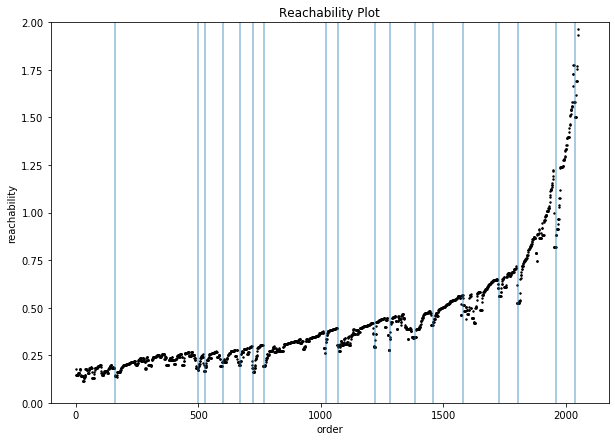

In [45]:
fig, ax = plt.subplots(figsize = (10,7))
for i in range(len(M)):
    ax.scatter(space[i], reachability[i], c = colors[-1], s=2)
ax.title.set_text("Reachability Plot")
ax.axvline(x=160, alpha = 0.5)
ax.axvline(x=500, alpha = 0.5)
ax.axvline(x=528, alpha = 0.5)
ax.axvline(x=600, alpha = 0.5)
ax.axvline(x=670, alpha = 0.5)
ax.axvline(x=725, alpha = 0.5)
ax.axvline(x=770, alpha = 0.5)
ax.axvline(x=1020, alpha = 0.5)
ax.axvline(x=1070, alpha = 0.5)
ax.axvline(x=1220, alpha = 0.5)
ax.axvline(x=1285, alpha = 0.5)
ax.axvline(x=1385, alpha = 0.5)
ax.axvline(x=1460, alpha = 0.5)
ax.axvline(x=1580, alpha = 0.5)
ax.axvline(x=1730, alpha = 0.5)
ax.axvline(x=1807, alpha = 0.5)
ax.axvline(x=1960, alpha = 0.5)
ax.axvline(x=2040, alpha = 0.5)
ax.set_xlabel("order")
ax.set_ylabel("reachability")
ax.set_xlim()
ax.set_ylim(0,2)
reach_plot_lines = plt.gcf()
plt.show()

In [46]:
for i in range(0,161):
    labels[order[i]] = 0
for i in range(161,501):
    labels[order[i]] = 1
for i in range(501,529):
    labels[order[i]] = 2
for i in range(529,601):
    labels[order[i]] = 3
for i in range(601,671):
    labels[order[i]] = 4
for i in range(671,726):
    labels[order[i]] = 5
for i in range(726,771):
    labels[order[i]] = 6
for i in range(771,1021):
    labels[order[i]] = 7
for i in range(1021,1071):
    labels[order[i]] = 8
for i in range(1071,1221):
    labels[order[i]] = 9
for i in range(1221,1286):
    labels[order[i]] = 10
for i in range(1286,1386):
    labels[order[i]] = 11
for i in range(1386,1461):
    labels[order[i]] = 12
for i in range(1461,1581):
    labels[order[i]] = 13
for i in range(1581,1731):
    labels[order[i]] = 14
for i in range(1731,1808):
    labels[order[i]] = 15
for i in range(1808,1961):
    labels[order[i]] = 16
for i in range(1961,2041):
    labels[order[i]] = 17
for i in range(2041, 2070):
    labels[order[i]] = -1
cvec = [colors[label] for label in labels]

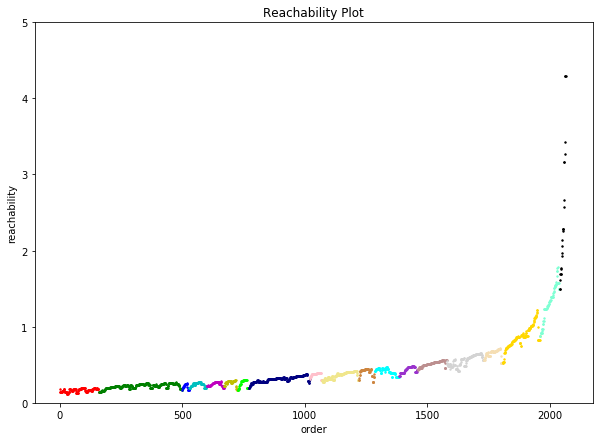

In [47]:
fig, ax = plt.subplots(figsize = (10,7))
for i in range(len(M)):
    ax.scatter(space[i], reachability[i], c = cvec[order[i]], s=2)
ax.title.set_text("Reachability Plot")
ax.set_xlabel("order")
ax.set_ylabel("reachability")
ax.set_ylim(0,5)
reach_plot = plt.gcf()
plt.show()

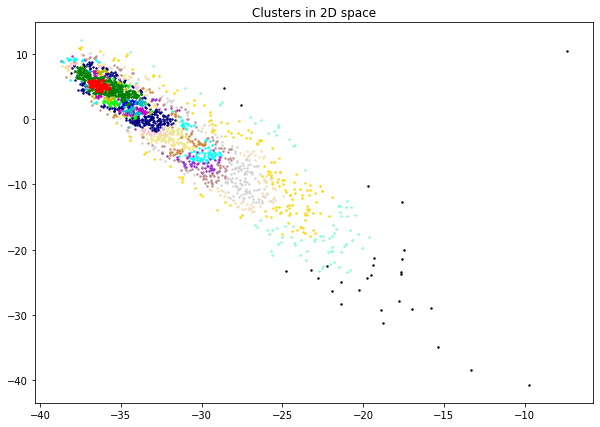

In [48]:
fig, ax = plt.subplots(figsize = (10,7))
for i in range(len(M)):
    ax.scatter(M[:,0][i], M[:,1][i], c = cvec[i], s=2)
ax.title.set_text("Clusters in 2D space")
clusters_2D = plt.gcf()
plt.show()

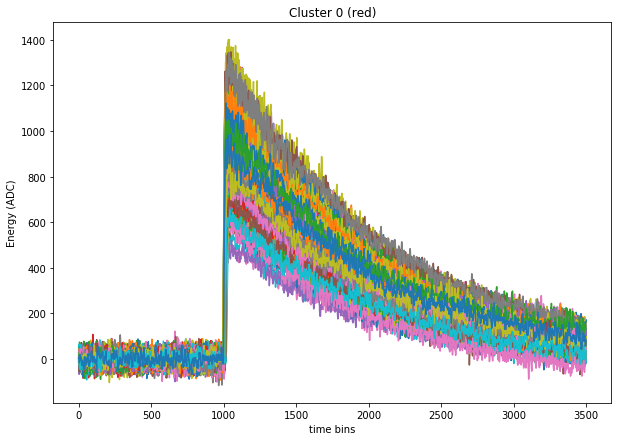

In [49]:
fig, ax = plt.subplots(figsize = (10, 7))
t = np.arange(3500)
for n in range(len(labels)):
    if labels[n] == 0:
        ax.plot(t, X[n])
        ax.title.set_text("Cluster 0 (red)")
        ax.set_xlabel("time bins")
        ax.set_ylabel("Energy (ADC)")
cluster0 = plt.gcf()
plt.show()

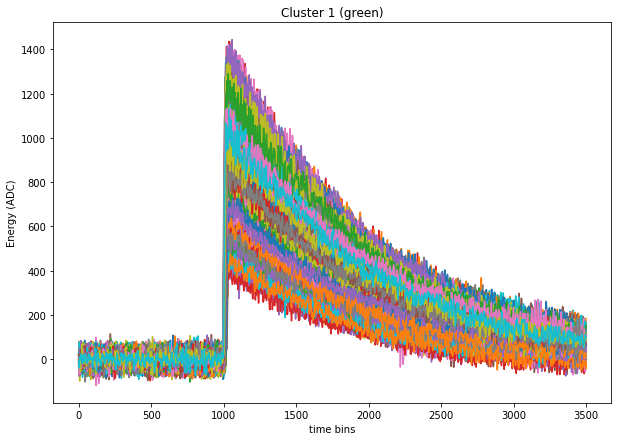

In [50]:
fig, ax = plt.subplots(figsize = (10, 7))
t = np.arange(3500)
for n in range(len(labels)):
    if labels[n] == 1:
        ax.plot(t, X[n])
        ax.title.set_text("Cluster 1 (green)")
        ax.set_xlabel("time bins")
        ax.set_ylabel("Energy (ADC)")
cluster1 = plt.gcf()
plt.show()

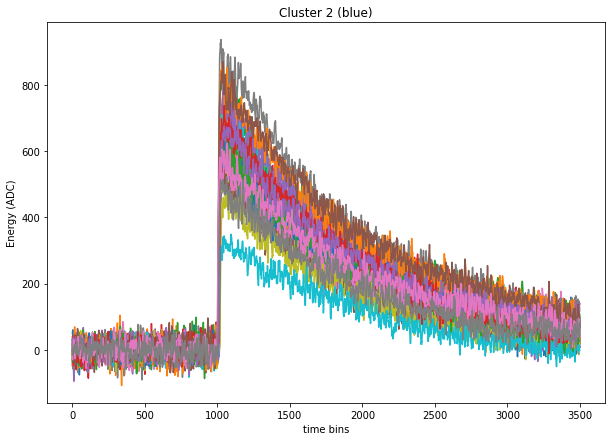

In [51]:
fig, ax = plt.subplots(figsize = (10, 7))
t = np.arange(3500)
for n in range(len(labels)):
    if labels[n] == 2:
        ax.plot(t, X[n])
        ax.title.set_text("Cluster 2 (blue)")
        ax.set_xlabel("time bins")
        ax.set_ylabel("Energy (ADC)")
cluster2 = plt.gcf()
plt.show()

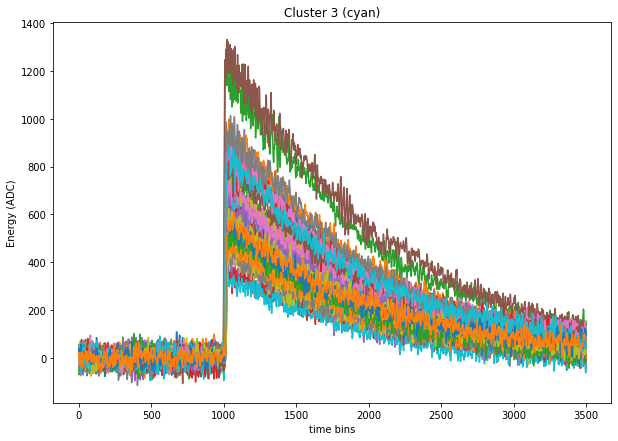

In [52]:
fig, ax = plt.subplots(figsize = (10, 7))
t = np.arange(3500)
for n in range(len(labels)):
    if labels[n] == 3:
        ax.plot(t, X[n])
        ax.title.set_text("Cluster 3 (cyan)")
        ax.set_xlabel("time bins")
        ax.set_ylabel("Energy (ADC)")
cluster3 = plt.gcf()
plt.show()

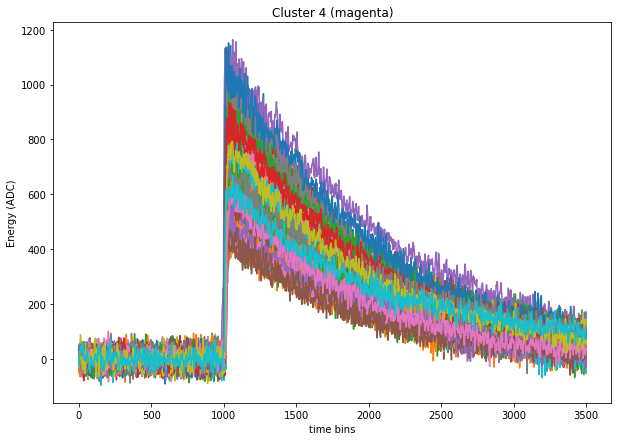

In [53]:
fig, ax = plt.subplots(figsize = (10, 7))
t = np.arange(3500)
for n in range(len(labels)):
    if labels[n] == 4:
        ax.plot(t, X[n])
        ax.title.set_text("Cluster 4 (magenta)")
        ax.set_xlabel("time bins")
        ax.set_ylabel("Energy (ADC)")
cluster4 = plt.gcf()
plt.show()

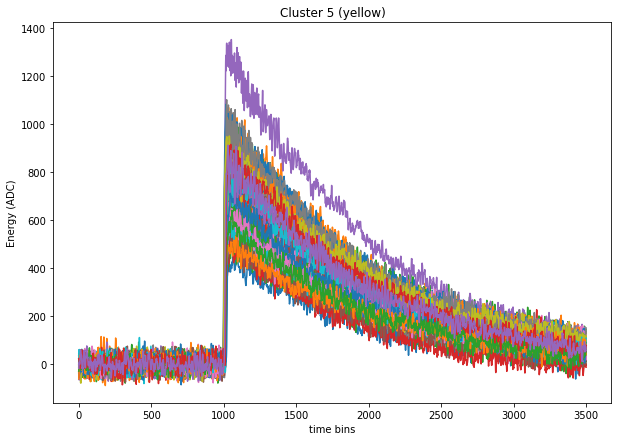

In [54]:
fig, ax = plt.subplots(figsize = (10, 7))
t = np.arange(3500)
for n in range(len(labels)):
    if labels[n] == 5:
        ax.plot(t, X[n])
        ax.title.set_text("Cluster 5 (yellow)")
        ax.set_xlabel("time bins")
        ax.set_ylabel("Energy (ADC)")
cluster5 = plt.gcf()
plt.show()

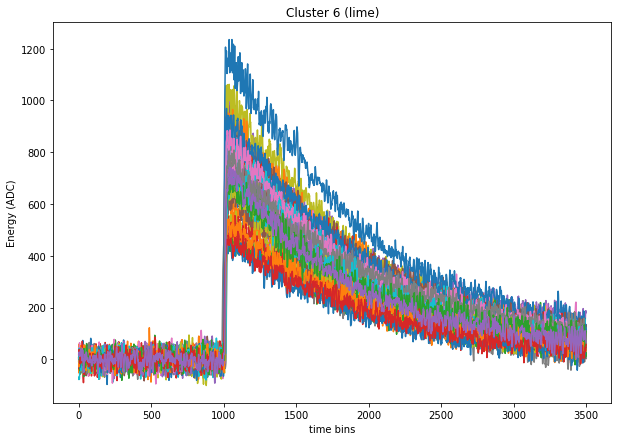

In [55]:
fig, ax = plt.subplots(figsize = (10, 7))
t = np.arange(3500)
for n in range(len(labels)):
    if labels[n] == 6:
        ax.plot(t, X[n])
        ax.title.set_text("Cluster 6 (lime)")
        ax.set_xlabel("time bins")
        ax.set_ylabel("Energy (ADC)")
cluster6 = plt.gcf()
plt.show()

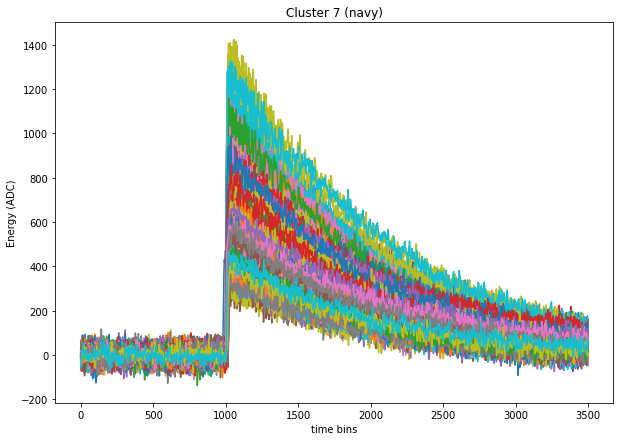

In [56]:
fig, ax = plt.subplots(figsize = (10, 7))
t = np.arange(3500)
for n in range(len(labels)):
    if labels[n] == 7:
        ax.plot(t, X[n])
        ax.title.set_text("Cluster 7 (navy)")
        ax.set_xlabel("time bins")
        ax.set_ylabel("Energy (ADC)")
cluster7 = plt.gcf()
plt.show()

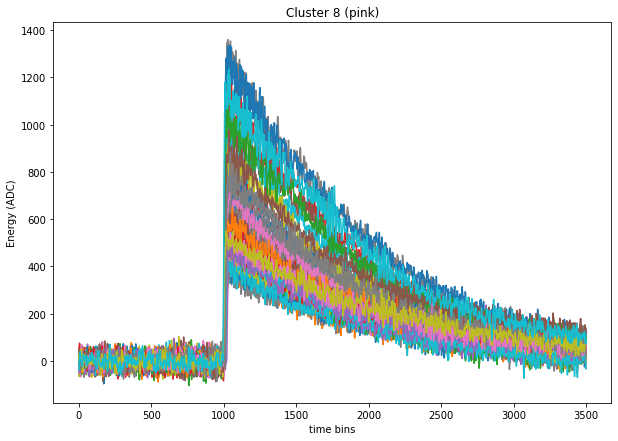

In [57]:
fig, ax = plt.subplots(figsize = (10, 7))
t = np.arange(3500)
for n in range(len(labels)):
    if labels[n] == 8:
        ax.plot(t, X[n])
        ax.title.set_text("Cluster 8 (pink)")
        ax.set_xlabel("time bins")
        ax.set_ylabel("Energy (ADC)")
cluster8 = plt.gcf()
plt.show()

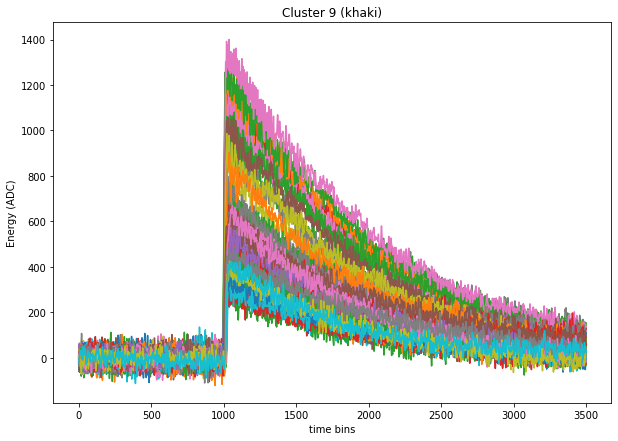

In [58]:
fig, ax = plt.subplots(figsize = (10, 7))
t = np.arange(3500)
for n in range(len(labels)):
    if labels[n] == 9:
        ax.plot(t, X[n])
        ax.title.set_text("Cluster 9 (khaki)")
        ax.set_xlabel("time bins")
        ax.set_ylabel("Energy (ADC)")
cluster9 = plt.gcf()
plt.show()

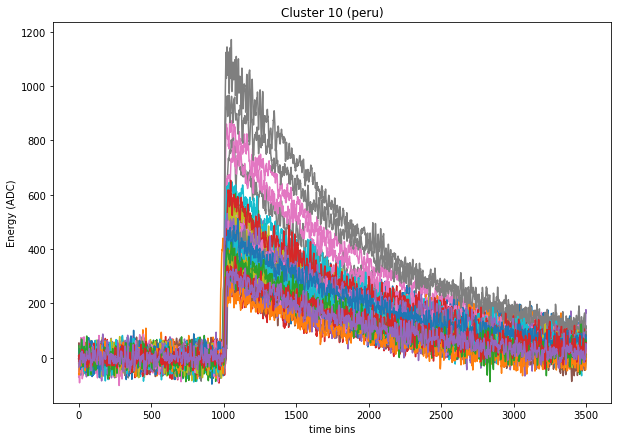

In [59]:
fig, ax = plt.subplots(figsize = (10, 7))
t = np.arange(3500)
for n in range(len(labels)):
    if labels[n] == 10:
        ax.plot(t, X[n])
        ax.title.set_text("Cluster 10 (peru)")
        ax.set_xlabel("time bins")
        ax.set_ylabel("Energy (ADC)")
cluster10 = plt.gcf()
plt.show()

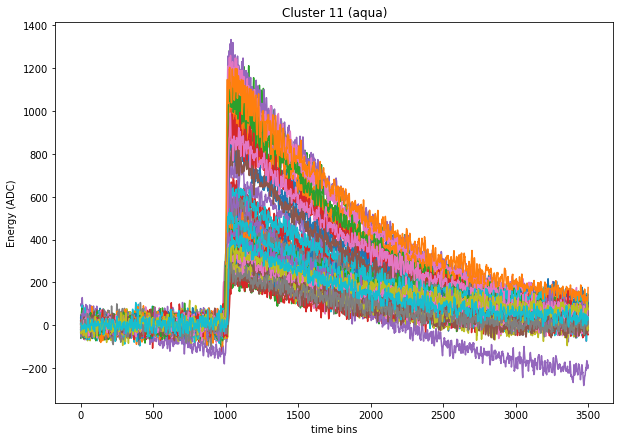

In [60]:
fig, ax = plt.subplots(figsize = (10, 7))
t = np.arange(3500)
for n in range(len(labels)):
    if labels[n] == 11:
        ax.plot(t, X[n])
        ax.title.set_text("Cluster 11 (aqua)")
        ax.set_xlabel("time bins")
        ax.set_ylabel("Energy (ADC)")
cluster11 = plt.gcf()
plt.show()

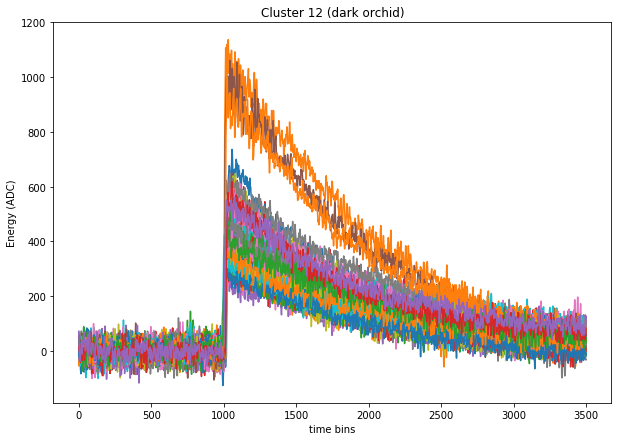

In [61]:
fig, ax = plt.subplots(figsize = (10, 7))
t = np.arange(3500)
for n in range(len(labels)):
    if labels[n] == 12:
        ax.plot(t, X[n])
        ax.title.set_text("Cluster 12 (dark orchid)")
        ax.set_xlabel("time bins")
        ax.set_ylabel("Energy (ADC)")
cluster12 = plt.gcf()
plt.show()

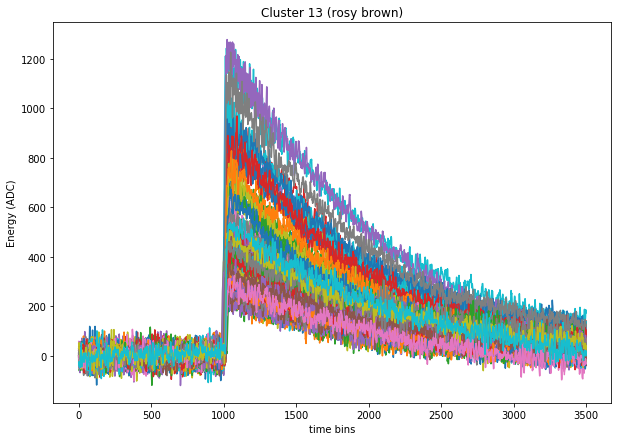

In [62]:
fig, ax = plt.subplots(figsize = (10, 7))
t = np.arange(3500)
for n in range(len(labels)):
    if labels[n] == 13:
        ax.plot(t, X[n])
        ax.title.set_text("Cluster 13 (rosy brown)")
        ax.set_xlabel("time bins")
        ax.set_ylabel("Energy (ADC)")
cluster13 = plt.gcf()
plt.show()

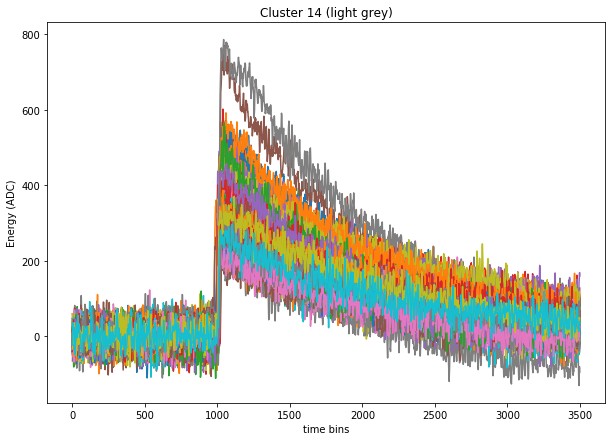

In [63]:
fig, ax = plt.subplots(figsize = (10, 7))
t = np.arange(3500)
for n in range(len(labels)):
    if labels[n] == 14:
        ax.plot(t, X[n])
        ax.title.set_text("Cluster 14 (light grey)")
        ax.set_xlabel("time bins")
        ax.set_ylabel("Energy (ADC)")
cluster14 = plt.gcf()
plt.show()

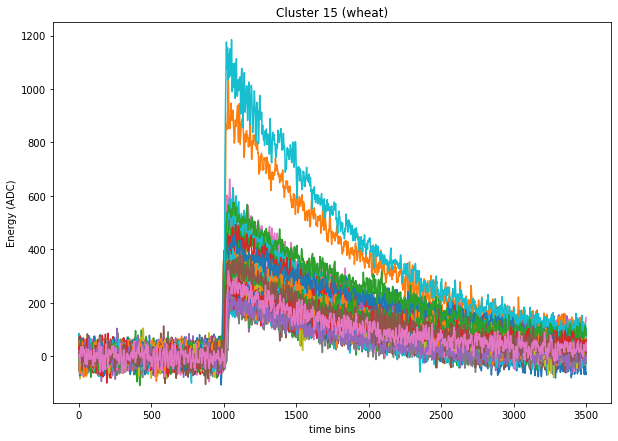

In [64]:
fig, ax = plt.subplots(figsize = (10, 7))
t = np.arange(3500)
for n in range(len(labels)):
    if labels[n] == 15:
        ax.plot(t, X[n])
        ax.title.set_text("Cluster 15 (wheat)")
        ax.set_xlabel("time bins")
        ax.set_ylabel("Energy (ADC)")
cluster15 = plt.gcf()
plt.show()

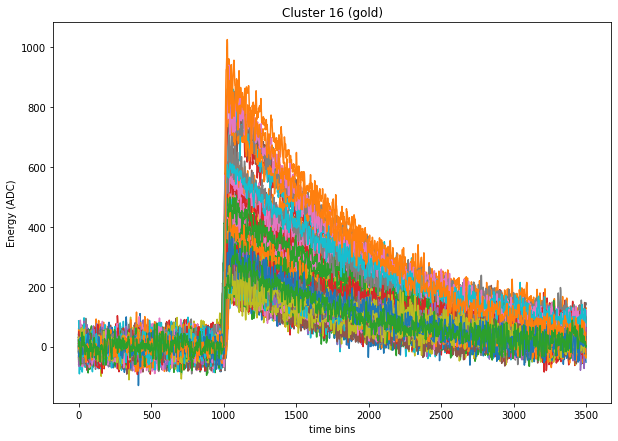

In [65]:
fig, ax = plt.subplots(figsize = (10, 7))
t = np.arange(3500)
for n in range(len(labels)):
    if labels[n] == 16:
        ax.plot(t, X[n])
        ax.title.set_text("Cluster 16 (gold)")
        ax.set_xlabel("time bins")
        ax.set_ylabel("Energy (ADC)")
cluster16 = plt.gcf()
plt.show()

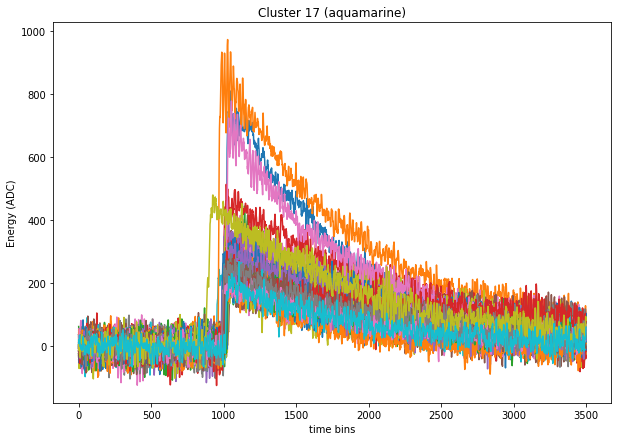

In [66]:
fig, ax = plt.subplots(figsize = (10, 7))
t = np.arange(3500)
for n in range(len(labels)):
    if labels[n] == 17:
        ax.plot(t, X[n])
        ax.title.set_text("Cluster 17 (aquamarine)")
        ax.set_xlabel("time bins")
        ax.set_ylabel("Energy (ADC)")
cluster17 = plt.gcf()
plt.show()

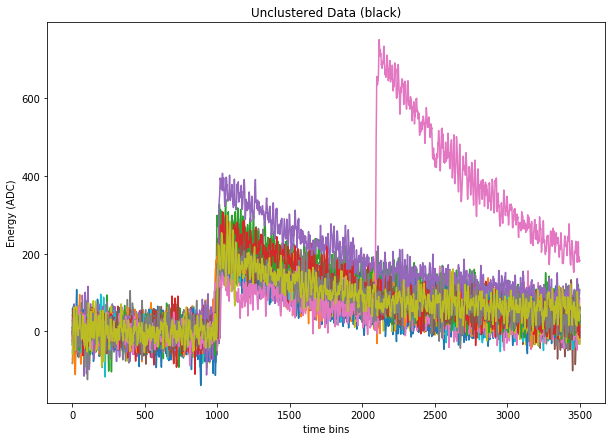

In [67]:
fig, ax = plt.subplots(figsize = (10, 7))
t = np.arange(3500)
for n in range(len(labels)):
    if labels[n] == -1:
        ax.plot(t, X[n])
        ax.title.set_text("Unclustered Data (black)")
        ax.set_xlabel("time bins")
        ax.set_ylabel("Energy (ADC)")
unclustered = plt.gcf()
plt.show()